In [2]:
#Builds 'n Installs
#!pip install scipy==1.2
!pip install -q --upgrade scipy;
!pip install -q --upgrade quandl;
!pip install -q --upgrade pandas-datareader;
!pip install -q --upgrade statsmodels;

     |████████████████████████████████| 8.7MB 2.7MB/s 


In [0]:
from statsmodels.tsa.stattools import adfuller
import requests
import warnings
import itertools
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss
import io
import scipy
import quandl
import numpy as np
import pandas as pd
import pandas_datareader as pdr
from pandas_datareader import data, wb
import fix_yahoo_finance as yf
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot
from matplotlib.pyplot import figure
from matplotlib.pyplot import style
import matplotlib.ticker as mtick
import datetime
from datetime import date
from dateutil.parser import parse
pd.options.display.float_format = '{:.2f}'.format
plt.rcParams["figure.figsize"] = (16,12)
plt.style.use('seaborn-white')
import matplotlib.dates as mdates

# Data 1

In [38]:
# load the data
datapath = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vT5bom_odHPyEve_zcusXJdnxAbhGZIlnmuPidHj-3bxsl-GsKwxJUwyvWltfgbwM4D28vXByyV8SvD/pub?gid=2139616052&single=true&output=csv'
y = pd.read_csv(datapath)
y

,Period,Value
0,Q1 '07,1.66
1,Q2 '07,1.59
2,Q3 '07,1.79
3,Q4 '07,3.12
4,Q1 '08,2.28
5,Q2 '08,2.23
6,Q3 '08,2.34
7,Q4 '08,3.69
8,Q1 '09,2.69
9,Q2 '09,2.56


In [39]:
def get_time(s):
  year = '20' + s[4:]
  month = int(s[1])*3
  if month in [3,6,9]:
    month_str = '0'+str(month)
  else:
    month_str = '12'
  return year + '-' + month_str

y['Period'] = y['Period'].apply(lambda row: get_time(row))
y.Period = pd.to_datetime(y.Period)
y = y.set_index('Period')
y

,Value
Period,
2007-03-01,1.66
2007-06-01,1.59
2007-09-01,1.79
2007-12-01,3.12
2008-03-01,2.28
2008-06-01,2.23
2008-09-01,2.34
2008-12-01,3.69
2009-03-01,2.69


## Q1: Predict the values for the next 8 time periods (with confidence intervals)


In [40]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [0]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
model_output = pd.DataFrame(columns = ['parameters', 'results.aic'])

a = "bob"
b = "bob"
c = 1.0

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            #Only for diagnostic measures
            #print('ARIMA{}x{}12 - AIC:{}'.format(param,
                                                  #param_seasonal, results.aic))
            a = param
            b = param_seasonal
            c = results.aic
            model_output = model_output.append({'parameters': 'ARIMA{}x{}12'.format(a, b),
                                                'results.aic': c}, ignore_index = True)
        except:
            continue

In [42]:
model_output.sort_values(by = 'results.aic').head(5)

,parameters,results.aic
41,"ARIMA(1, 1, 0)x(1, 1, 0, 12)12",41.37
47,"ARIMA(1, 1, 1)x(1, 1, 0, 12)12",43.36
35,"ARIMA(1, 0, 1)x(1, 1, 0, 12)12",44.28
23,"ARIMA(0, 1, 1)x(1, 1, 0, 12)12",51.04
29,"ARIMA(1, 0, 0)x(1, 1, 0, 12)12",52.35


In [43]:
#Fit the model with the lowest AIC above

mod = sm.tsa.statespace.SARIMAX(y.Value,
                                order=(1, 1, 0),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1471      0.217      5.295      0.000       0.722       1.572
ar.S.L12       0.8661      0.091      9.493      0.000       0.687       1.045
sigma2         0.4176      0.182      2.290      0.022       0.060       0.775


In [45]:
results.get_prediction(start = pd.to_datetime('2018-03-01'), end = pd.to_datetime('2019-12-01'), dynamic=False)

In [46]:
#Validation - not dynamic 
pred = results.get_prediction(start = pd.to_datetime('2018-03-01'), end = pd.to_datetime('2019-12-01'), dynamic=False)
pred_ci = pred.conf_int()
pred_ci

,lower Value,upper Value
2018-03-01,31.10,33.63
2018-06-01,34.43,40.43
2018-09-01,38.95,49.57
2018-12-01,48.94,65.42
2019-03-01,47.70,71.36
2019-06-01,52.50,84.82
2019-09-01,57.83,100.45
2019-12-01,69.09,123.86


In [49]:
# forecasted value for 8 post quarters
y_forecasted = pred.predicted_mean
y_forecasted

2018-03-01   32.36
2018-06-01   37.43
2018-09-01   44.26
2018-12-01   57.18
2019-03-01   59.53
2019-06-01   68.66
2019-09-01   79.14
2019-12-01   96.47
Freq: QS-DEC, dtype: float64

## Q2: Make 3 observations about the data (i.e., describe its composition and characteristics)


* Although there are ups and downs at every point in time, generally we can observe that the trend increases. Also we can notice how the ups and downs seem to be a bit regular, it means we might be observing a seasonal pattern here too.
* Trend is increasing through the years.
* From the seasonal trend, we can find that the peak of the value in each year is almost the same. 
* The residual plot shows that the year between 2011 to a half of 2013 remains steady which is near zero. 

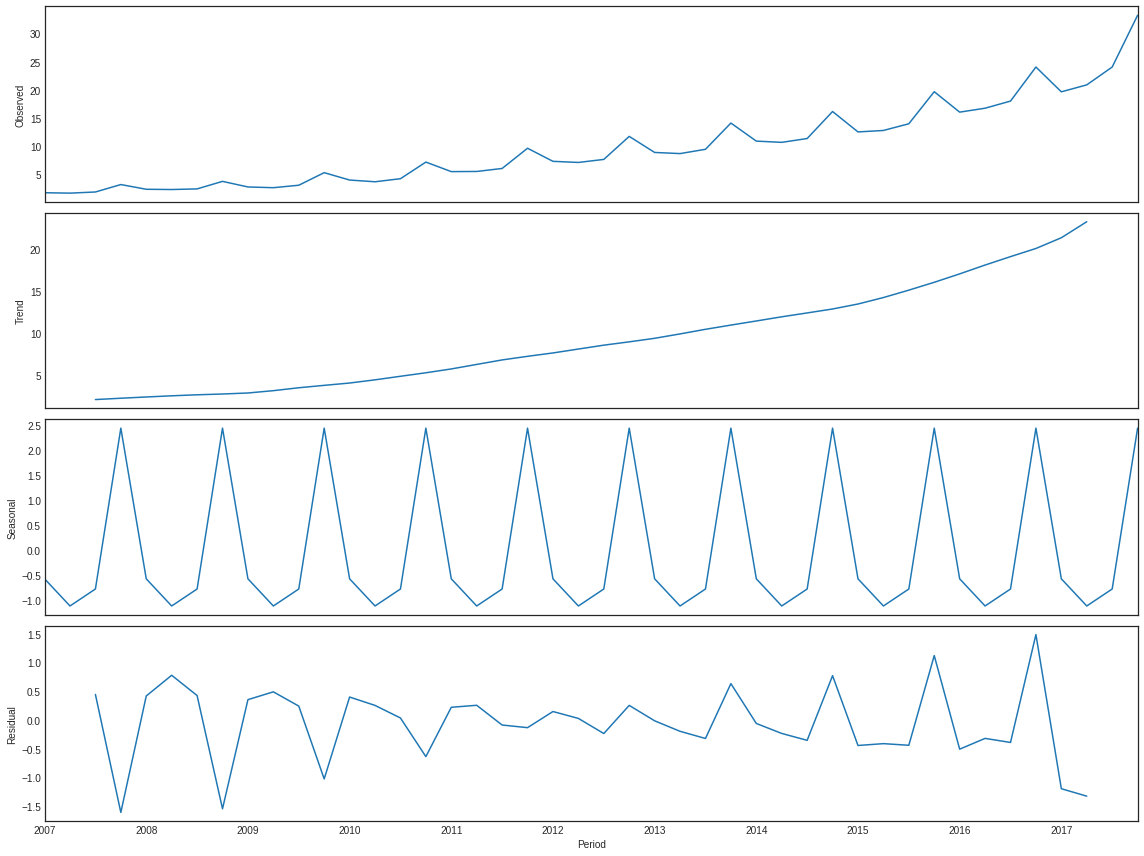

In [50]:
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

## Q3: What leads you to believe that your predictions are correct / incorrect?


Noted that our validation set is 2017 from Q1 to Q4. We calculated the MSE is 0.76, which means the predict values are pretty close to the true values. Therefore, we believe that our predictions are correct.

In [59]:
pred = results.get_prediction(start=pd.to_datetime('2017-03-01'), dynamic=False)
y_forecasted = pred.predicted_mean
y_truth = y['2017-03-01':]
mse = ((np.array(y_forecasted) - np.array(y_truth).reshape(-1)) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.76


In [60]:
y_forecasted

2017-03-01   19.42
2017-06-01   19.34
2017-09-01   23.61
2017-12-01   32.63
Freq: QS-DEC, dtype: float64

In [61]:
y_truth

,Value
Period,
2017-03-01,19.64
2017-06-01,20.88
2017-09-01,24.06
2017-12-01,33.27
